In [15]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import intake
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
from pyxpcm.pcmodel import pcm

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib as mpl

Let's get started with loading some sample data to work with:

In [16]:
ds = pyxpcm.tutorial.open_dataset('isas_snapshot').load()
print(ds)
print('This dataset holds: %.0f MB' % (ds.nbytes / 1e6))

<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61)
Coordinates:
  * latitude     (latitude) float32 30.023445 30.455408 ... 49.41288 49.737103
  * longitude    (longitude) float32 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    TEMP         (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    TEMP_ERR     (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    TEMP_PCTVAR  (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    PSAL         (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    PSAL_ERR     (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    PSAL_PCTVAR  (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61

## Define a PCM

In [3]:
# Define vertical axis and features to use:
z = ds['depth'].where(ds['depth']>=-1200, drop=True)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

# features_pcm = {'temperature': z, 'sst': None}
# features_in_ds = {'temperature': 'TEMP', 'sst': 'SST'}

# Note that here we use the dataset vertical axis for performance reasons (no need for interpolation)
# We could use anything, eg: z = np.arange(0,-1000,-10)

In [4]:
m = pcm(K=3, features=features_pcm)
m

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>

### Plot the domain where data are available for this PCM

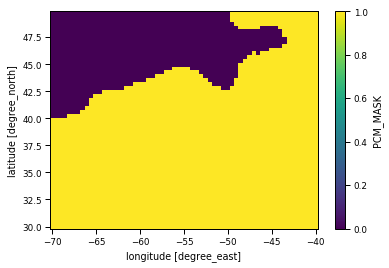

In [5]:
mask = ds.pyxpcm.mask(m, features=features_in_ds, dim='depth')
mask.plot()

## Fit

In [6]:
ds.pyxpcm.fit(m, features=features_in_ds, dim='depth')
# or: m.fit(ds, features=features_in_ds, dim='depth')

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 63.220249

## Predictions

In [7]:
# Hard/Fuzzy classify data:
ds = ds.pyxpcm.predict(m, features=features_in_ds, dim='depth', inplace=True)
ds = ds.pyxpcm.predict_proba(m, features=features_in_ds, dim='depth', inplace=True)

# Compute robustness of the classification:
ds = ds.pyxpcm.robustness(inplace=True)
ds = ds.pyxpcm.robustness_digit(inplace=True)

# Compute quantiles:
ds = ds.compute() # This is necessary if data are in dask arrays
for vname in ['TEMP', 'PSAL']:
    ds = ds.pyxpcm.quantile([0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

print(ds)

<xarray.Dataset>
Dimensions:             (depth: 152, latitude: 53, longitude: 61, pcm_class: 3, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2
  * latitude            (latitude) float64 30.02 30.46 30.89 ... 49.41 49.74
  * longitude           (longitude) float64 -70.0 -69.5 -69.0 ... -40.5 -40.0
  * depth               (depth) float32 -1.0 -3.0 -5.0 ... -1980.0 -2000.0
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    TEMP                (depth, latitude, longitude) float32 24.458 ... 3.4309998
    TEMP_ERR            (depth, latitude, longitude) float32 0.33 ... 0.049000002
    TEMP_PCTVAR         (depth, latitude, longitude) float32 31.0 31.0 ... 99.0
    PSAL                (depth, latitude, longitude) float32 36.632 ... 34.917
    PSAL_ERR            (depth, latitude, longitude) float32 0.051000003 ... 0.006
    PSAL_PCTVAR         (depth, latitude, longitude) float32 32.0 32.0 ... 99.0
    SST                 (latitude, longi

In [8]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.clean()
# print('After cleaning:', ds.data_vars)

## Maps

### Labels

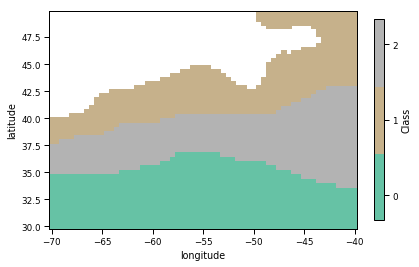

In [9]:
# Easiest way of ploting results:
cmap = m.plot.cmap()
ds['PCM_LABELS'].plot(cmap=cmap, add_colorbar=False)
cl = m.plot.colorbar()

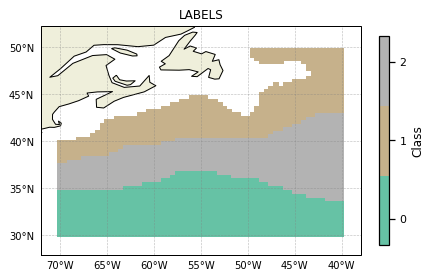

In [10]:
# Nicer map:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=90, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap()
ds['PCM_LABELS'].plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=m.K, add_colorbar=False)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, fontsize=8, dx=5)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS')
plt.show()

### Probabilities of classes for each data point

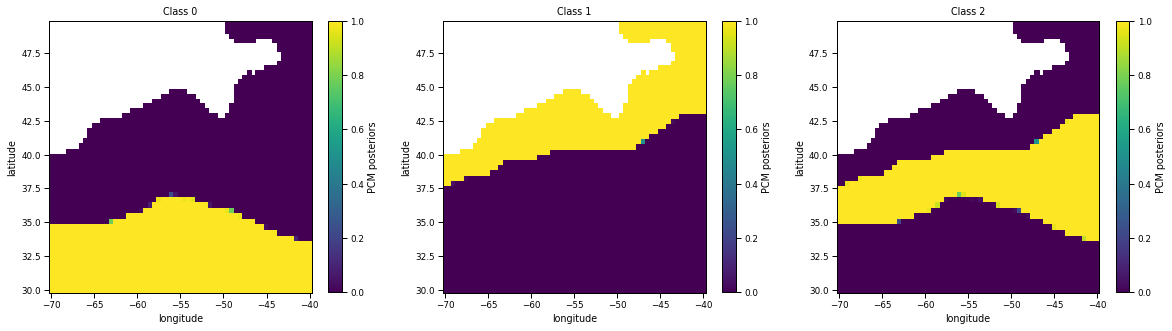

In [11]:
# Easiest way of ploting results:
fig, ax = m.plot.subplots(figsize=(20,5))
for k in m:
    ds['PCM_POST'].sel(pcm_class=k).plot(ax=ax[k])
    ax[k].set_title("Class %i" % k)

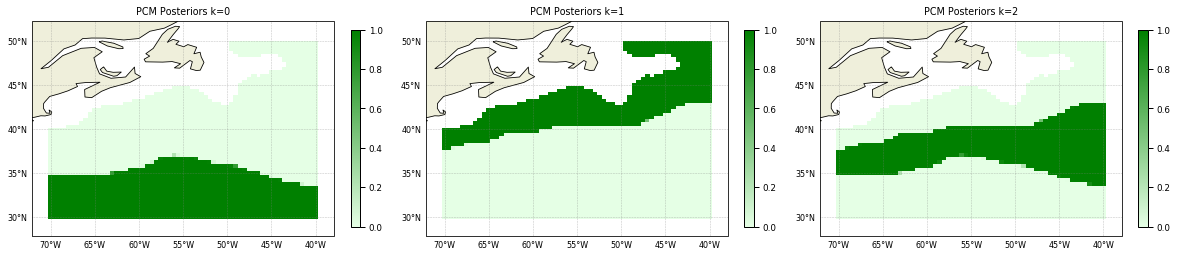

In [12]:
# Nicer maps:
cmap = sns.light_palette("green", as_cmap=True)
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = m.plot.subplots(figsize=(20,5),subplot_kw=subplot_kw)
for k in m:
    sc = ds['PCM_POST'].sel(pcm_class=k).plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=1, add_colorbar=False, ax=ax[k])
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    gl = m.plot.latlongrid(ax[k], fontsize=8, dx=5, dy=5)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].set_title('PCM Posteriors k=%i' % k)

### Robustness

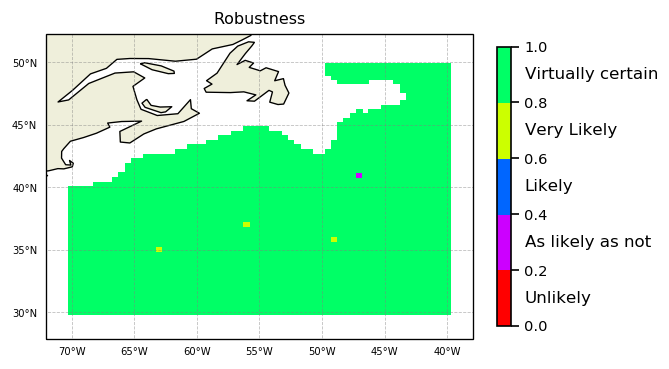

In [13]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap(usage='robustness')
boundaries = ds['PCM_ROBUSTNESS_CAT'].attrs['bins']
rowl0 = ds['PCM_ROBUSTNESS_CAT'].attrs['legend']
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
sc = ds['PCM_ROBUSTNESS'].plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=1, add_colorbar=False, ax=ax)
cl = plt.colorbar(sc, ax=ax, fraction=0.03)
for (i,j) in zip(np.arange(0.1,1,1/5), rowl0):
    cl.ax.text(2, i, j, ha='left', va='center')

gl = m.plot.latlongrid(ax)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Robustness')
plt.show()

## Profiles

### Quantiles

Used to plot the typical class profiles

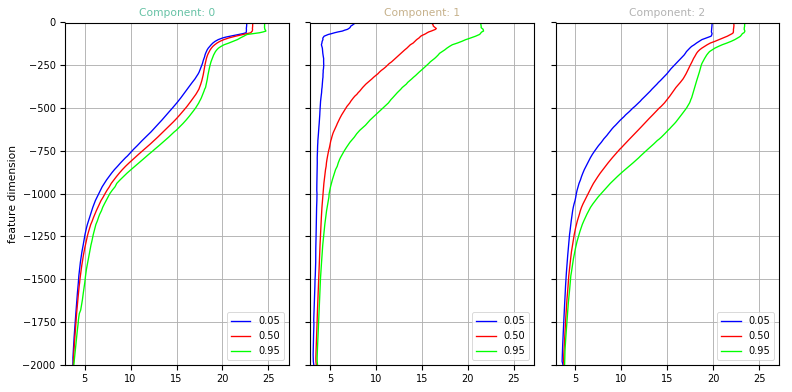

In [14]:
fig, ax = m.plot.quantile(ds['TEMP_Q'], maxcols=4, figsize=(10, 5), sharey=True)